In [1]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# no blurry plots!
%config InlineBackend.figure_format = 'retina'

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption style='font-weight: bold; font-size: large'>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering `%%black` at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering `%%black` at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">

# Part 1: Spectral Methods Intuition

## Goal

In this exercise you will build some intuition for the eigenvectors of various simple graphs.

</div>

In [2]:
from matplotlib import pyplot as plt
import numpy as np

<div class="custom-assignment-text">
    
## Description

(a) (6 points) Consider the graphs as given in Figure 1. For this part, take $n = 6$. For each graph write down the Laplacian matrix $L = D −A$ where $D$ is the diagonal matrix with entry $D_{i,j}$ being the degree of the $i$th node, and $A$ is the adjacency matrix, with entry $A_{i,j} = 1$ if there is an edge between nodes $i$ and $j$, and $A_{i,j} = 0$ otherwise. Your answer should be in the form of actual matrices (i.e., not just English descriptions of matrices).
    
<figure><center><img src="../../materials/Week 6/Figure_1.png" width=100%><figcaption>Figure 1: The graphs for question 1a.</figcaption></center></figure>

</div>

In [3]:
class Graph():
    def __init__(self, n):
        self.n = n
        self.D = np.zeros((n, n))
        self.A = np.zeros((n, n))
    def add_edge(self, i, j, weight=1):
        self.D[i,i] += weight
        self.D[j,j] += weight
        self.A[i,j] += weight
        self.A[j,i] += weight
        
    def get_laplacian(self):
        return self.D - self.A

In [5]:
def line_graph(n=6):
    graph = Graph(n)
    for i in range(n-1):
        graph.add_edge(i, i+1)
    return graph

def line_with_point_graph(n=6):
    graph = line_graph(n)
    for i in range(n-2):
        graph.add_edge(i, n-1)
    return graph

def circle_graph(n=6):
    graph = line_graph(n)
    # close the circle
    graph.add_edge(0, n-1)
    return graph

def circle_with_point_graph(n=6):
    graph = line_graph(n)
    # close the circle
    graph.add_edge(0, n-2)
    # connect points to center (n-2 is already connected to n-1)
    for i in range(0, n-2):
        graph.add_edge(i, n-1)
    return graph
    

def test_graphs(graph_constructors):
    for name, f in graph_constructors.items():
        n = 100
        matrix = f(n).get_laplacian()
        assert matrix.shape == (n,n), f'{name}: {matrix.shape}'
        # graph should be symmetric
        assert np.allclose(matrix, matrix.T)
        # diagonal should be non-negative, others non-positive
        for i in range(n):
            for j in range(n):
                if i == j:
                    assert matrix[i,j] >= 0, f'{name}: {matrix[i,j]}'
                else:
                    assert matrix[i,j] <= 0, f'{name}: {matrix[i,j]}'
        
GRAPHERS = {"(a) Line graph": line_graph, "(b) Line graph with added point": line_with_point_graph, "(c) Circle graph": circle_graph, "(d) Circle graph with added point": circle_with_point_graph}        
test_graphs(GRAPHERS)
ok()

In [6]:
for label, grapher in GRAPHERS.items():
    markdown(f'#### {label}')
    print(grapher().get_laplacian())

#### (a) Line graph

[[ 1. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  1.]]


#### (b) Line graph with added point

[[ 2. -1.  0.  0.  0. -1.]
 [-1.  3. -1.  0.  0. -1.]
 [ 0. -1.  3. -1.  0. -1.]
 [ 0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1.  2. -1.]
 [-1. -1. -1. -1. -1.  5.]]


#### (c) Circle graph

[[ 2. -1.  0.  0.  0. -1.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [-1.  0.  0.  0. -1.  2.]]


#### (d) Circle graph with added point

[[ 3. -1.  0.  0. -1. -1.]
 [-1.  3. -1.  0.  0. -1.]
 [ 0. -1.  3. -1.  0. -1.]
 [ 0.  0. -1.  3. -1. -1.]
 [-1.  0.  0. -1.  3. -1.]
 [-1. -1. -1. -1. -1.  5.]]


<div class="custom-assignment-text">

(b) (9 points) For each of the graphs of question (a), compute the eigenvectors and eigenvalues of the Laplacian matrix L and the adjacency matrix $A$, when there are $n = 100$ vertices. For both $L$ and $A$, plot the eigenvectors corresponding to the two smallest and two largest eigenvalues. Please include eight plots; two for each graph with one corresponding to the eigenvectors of $L$ and one
corresponding to $A$. Clearly label the four eigenvectors on each plot. (When plotting an eigenvector $v$, the x-axis ranges from $1$ through $n$, and the $i$th point is plotted at location $(i, \mathbf{v}(i))$.) In light of the interpretation of $\mathbf{v}^{\top}L\mathbf{v} = \frac{1}{2}\sum_{(i,j)∈E}(\mathbf{v}(i)-\mathbf{v}(j))^2$, explain why these eigenvectors make sense. One brief (2-4 sentence) explanation is sufficient.

</div>

Graph,A: largest,A: second largest,A: second smallest,A: smallest,L: largest,L: second largest,L: second smallest,L: smallest
(a) Line graph,1.999,1.9961,-1.9961,-1.999,3.999,3.9961,0.001,-0.0
(b) Line graph with added point,10.9899,1.9961,-1.999,-9.0101,100.0,4.999,1.001,-0.0
(c) Circle graph,2.0,1.9961,-1.9961,-2.0,4.0,3.9961,0.0039,-0.0
(d) Circle graph with added point,11.0,1.996,-1.999,-9.0,100.0,4.999,1.004,0.0


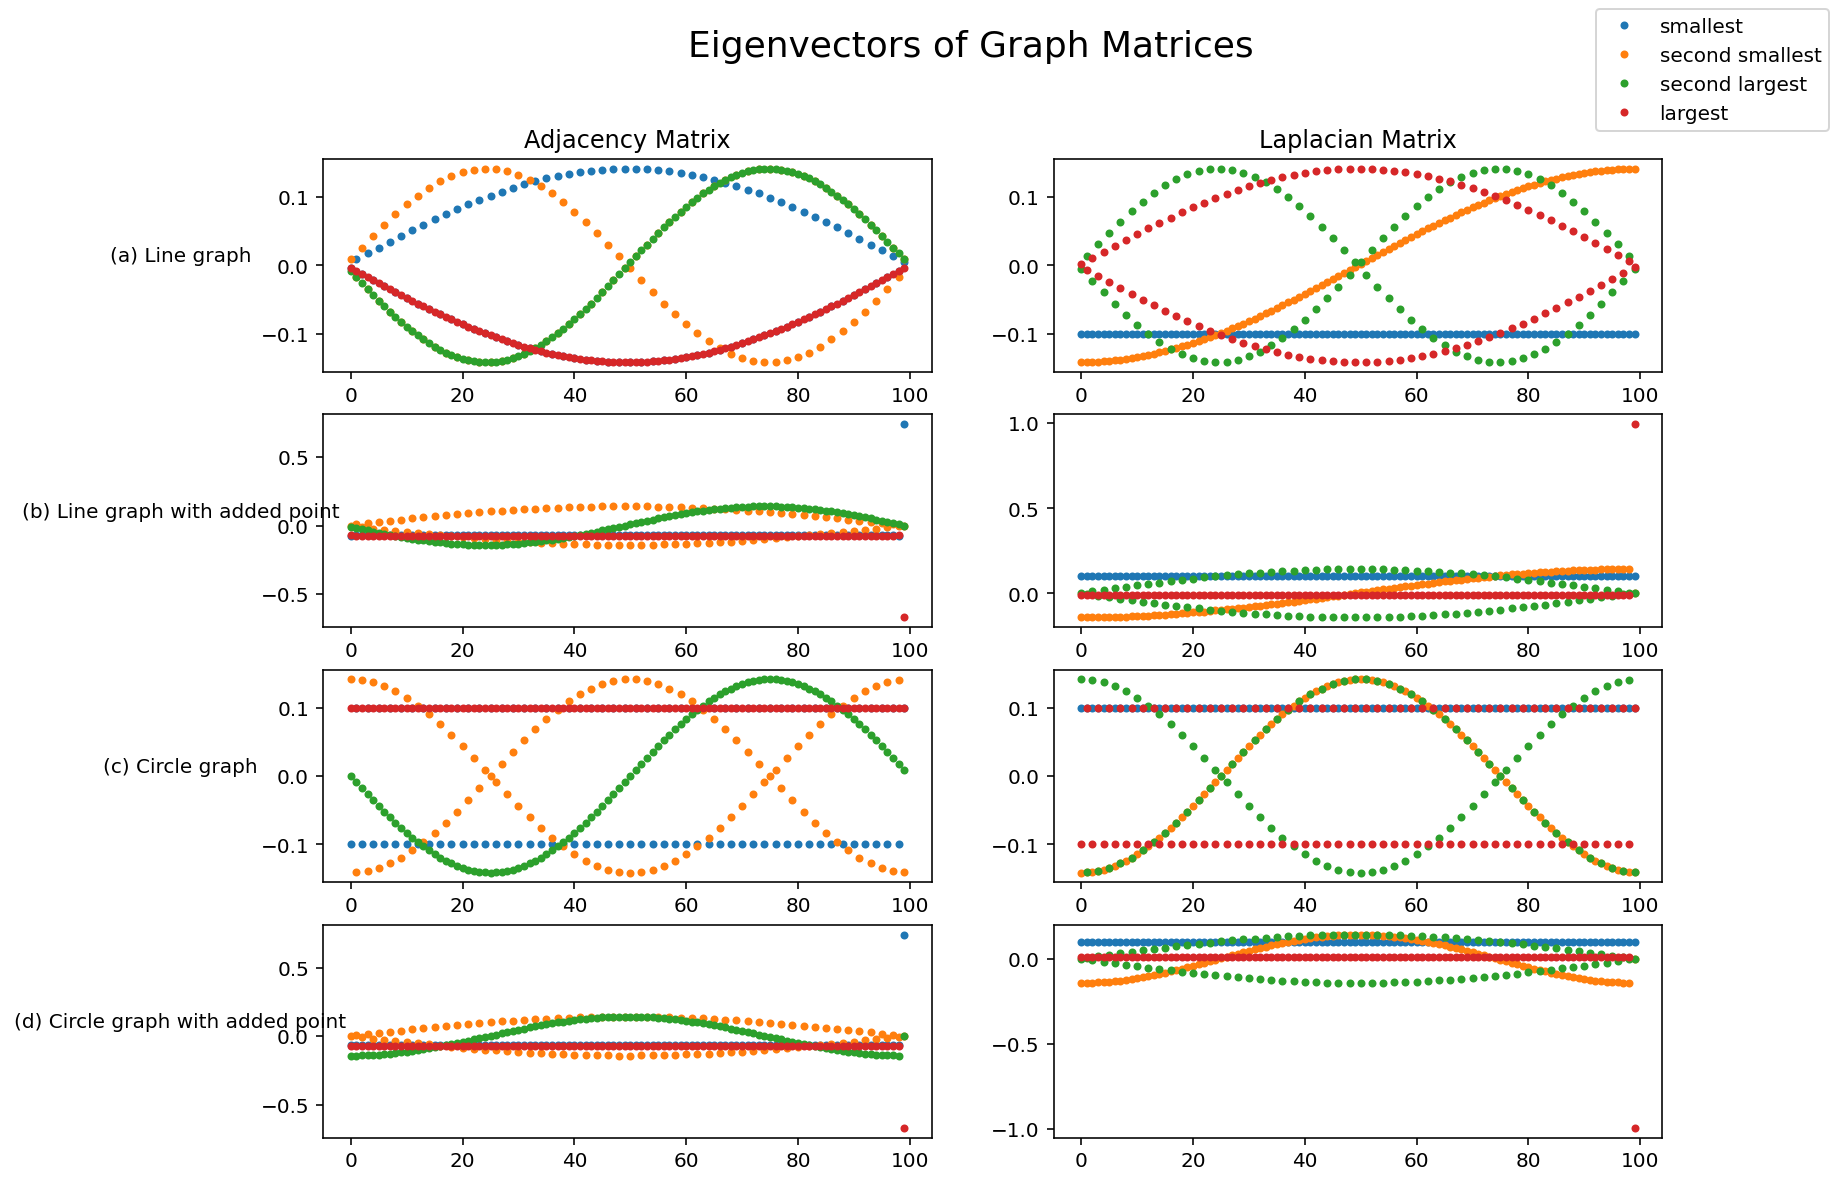

In [7]:
def plot_eigenvectors(n=100):
    eigen_values = []
    fig, axs = plt.subplots(len(GRAPHERS), 2, figsize=(12, 9))
    for (ax_row, (label, grapher)) in zip(axs, GRAPHERS.items()):
        #         ax_row[0].set_title(label)
        g = grapher(100)
        A_eigen_values, A_eigen_vectors = np.linalg.eigh(g.A)
        ax_row[0].plot(A_eigen_vectors[:, 0], ".", label="smallest", linestyle="None")
        ax_row[0].plot(
            A_eigen_vectors[:, 1], ".", label="second smallest", linestyle="None"
        )
        ax_row[0].plot(
            A_eigen_vectors[:, -2], ".", label="second largest", linestyle="None"
        )
        ax_row[0].plot(A_eigen_vectors[:, -1], ".", label="largest", linestyle="None")
        ax_row[0].set_ylabel(label, rotation=0, labelpad=40)

        L_eigen_values, L_eigen_vectors = np.linalg.eigh(g.get_laplacian())
        ax_row[1].plot(L_eigen_vectors[:, 0], ".", label="smallest", linestyle="None")
        ax_row[1].plot(
            L_eigen_vectors[:, 1], ".", label="second smallest", linestyle="None"
        )
        ax_row[1].plot(
            L_eigen_vectors[:, -2], ".", label="second largest", linestyle="None"
        )
        ax_row[1].plot(L_eigen_vectors[:, -1], ".", label="largest", linestyle="None")

        eigen_values.append(
            [label]
            + list(map(
                lambda x: round(x, 4),
                [
                    A_eigen_values[-1],
                    A_eigen_values[-2],
                    A_eigen_values[1],
                    A_eigen_values[0],
                    L_eigen_values[-1],
                    L_eigen_values[-2],
                    L_eigen_values[1],
                    L_eigen_values[0],
                ],
            ))
        )

    axs[0, 0].set_title("Adjacency Matrix")
    axs[0, 1].set_title("Laplacian Matrix")
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.suptitle("Eigenvectors of Graph Matrices", fontsize=18)

    display_table(
        eigen_values,
        "Eigen Values of Graph Matrices",
        [
            "Graph",
            "A: largest",
            "A: second largest",
            "A: second smallest",
            "A: smallest",
            "L: largest",
            "L: second largest",
            "L: second smallest",
            "L: smallest",
        ],
    )


plot_eigenvectors()

Observations:

1) b) and d) have outlier values at index $n$ because there is one point which is extremely connected; other than the single outlier, the graphs are the same as in a) and c) (they look quite different but it's just because the rest of the plot is squished due to the scaling caused by the outlier).

2) The largest and smallest eigenvectors for c) and d) (the circle graphs) are straight lines because every vertex is (or most vertices are) equally connected. I'm uncertain how to interpret the straight lines in a) and b).

3) There appears to be a pattern of the largest eigenvector being a low frequency sine wave, then the frequency increasing for smaller eigenvalues, then the phase reversing and the frequency going down again for the smallest eigenvectors.

4) The Laplacians each have 1 0-eigenvalue, since each graph is connected.


<div class="custom-assignment-text">

(c) (6 points) For this question, you will consider each of the 4 graphs of part (a) in the case that $n = 100$. For each such $n = 100$ node graph, plot the embedding of the graph onto the eigenvectors corresponding to the 2nd and 3rd smallest eigenvalues of the Laplacian. That is: if $\mathbf{v}_2$ is the second eigenvector and $\mathbf{v}_3$ is the third eigenvector of the Laplacian, create a scatter plot with the points $(\mathbf{v}_2(i), \mathbf{v}_3(i))$ for $i ∈ {1, ... 100}$. Overlay the edges of the graph, i.e. for every pair of points $i, j$, that are connected in the graph $G$, draw an edge between $(\mathbf{v}_2(i), \mathbf{v}_3(i))$ and $(\mathbf{v}_2(j), \mathbf{v}_3(j))$.

</div>

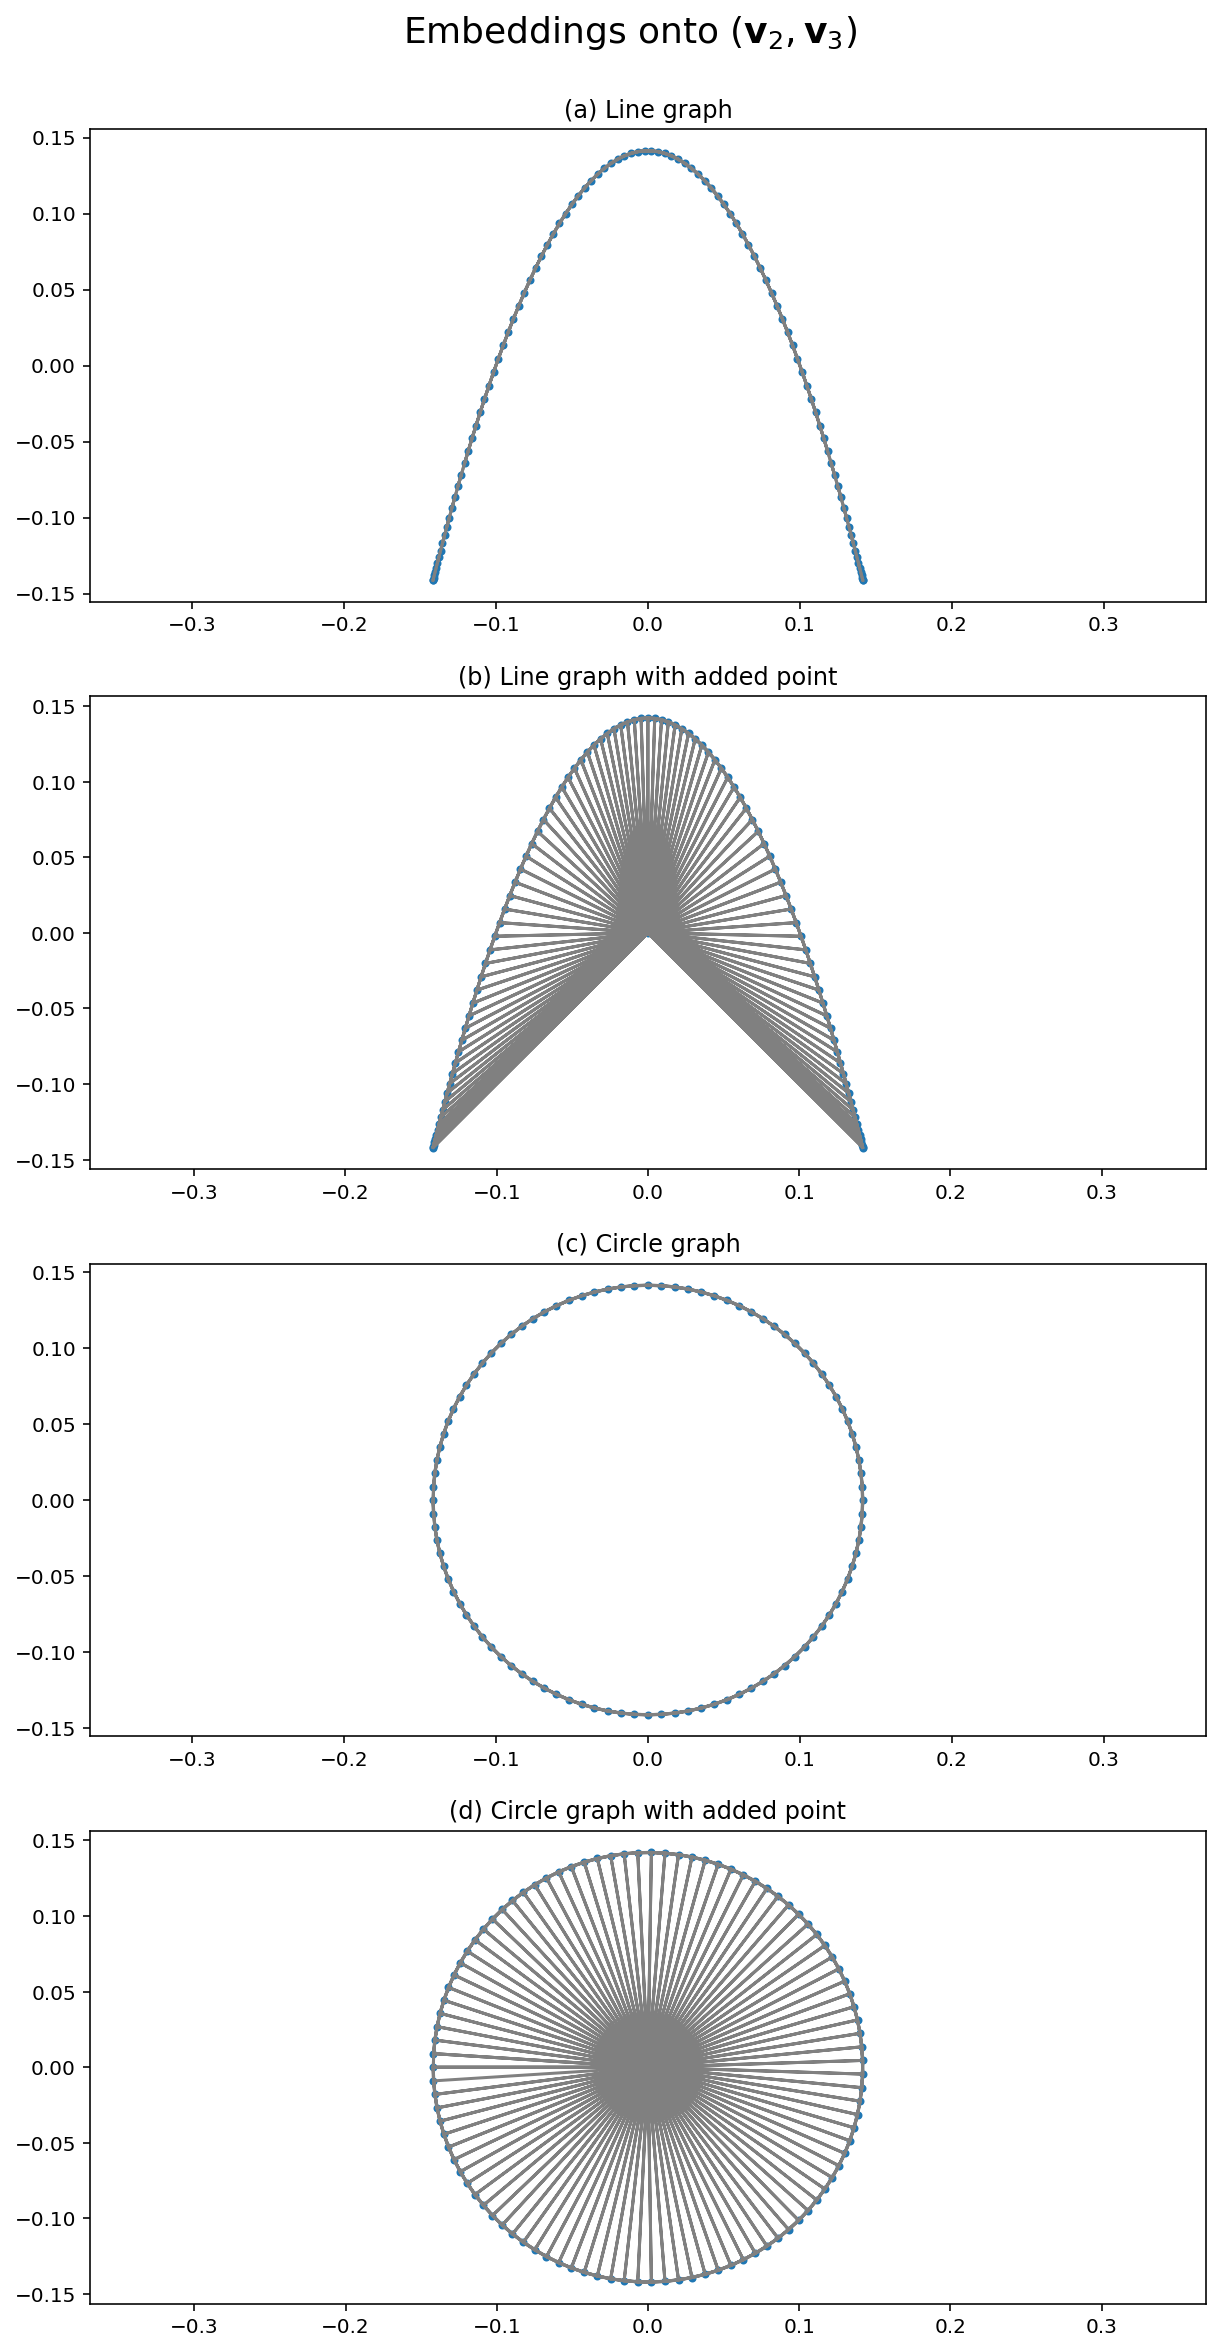

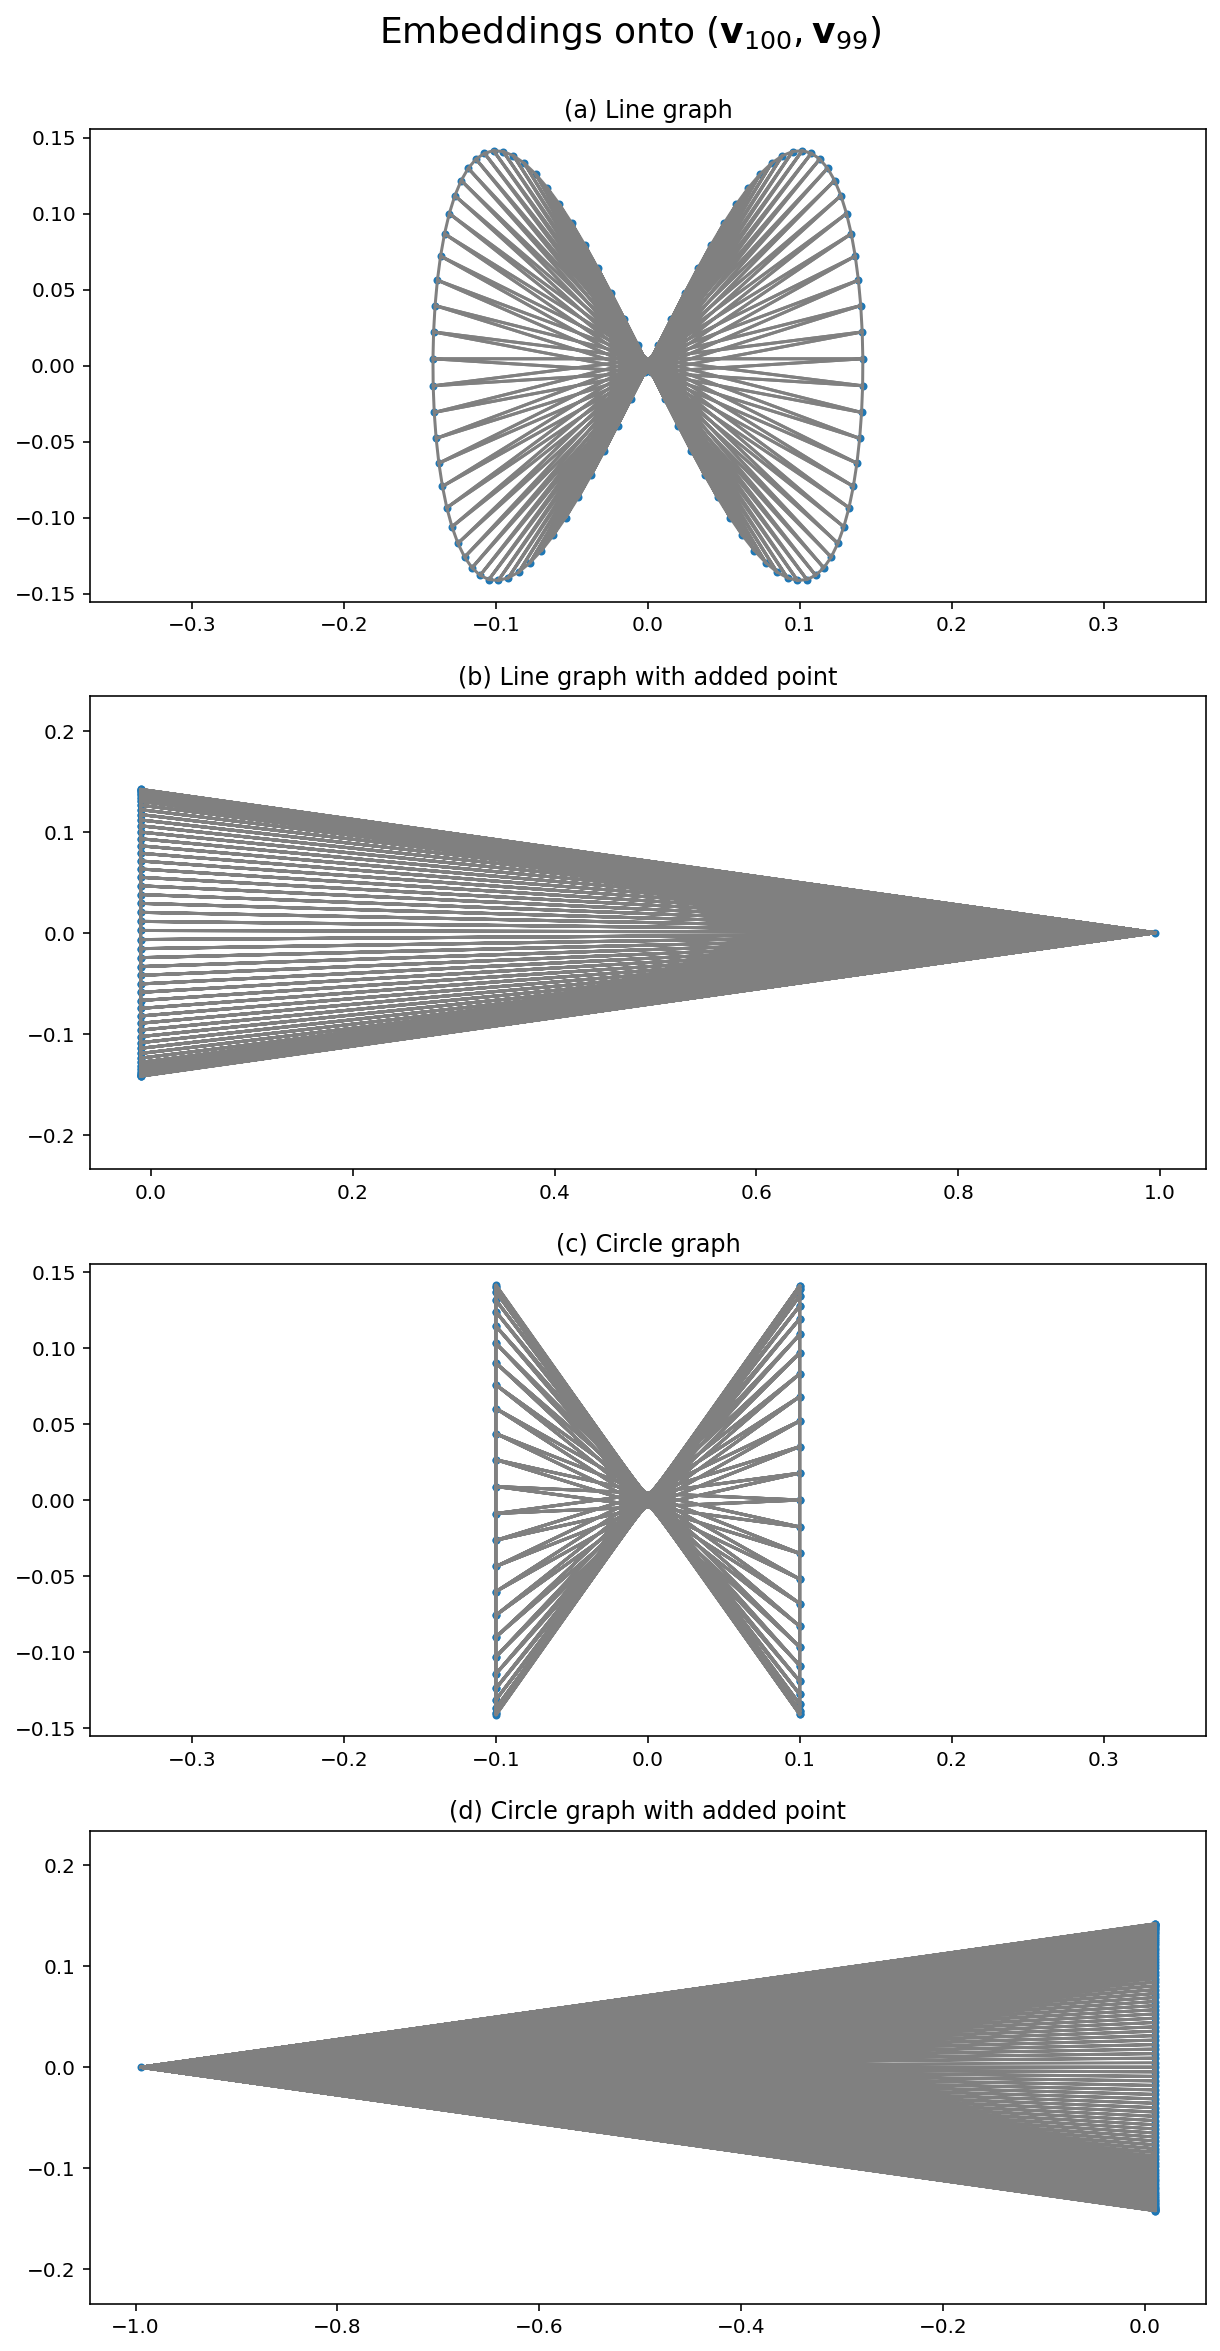

In [37]:
def plot_embeddings(n=100, largest=False):
    eigen_values = []
    fig, axs = plt.subplots(len(GRAPHERS), 1, figsize=(10,20))
    for (ax_row, (label, grapher)) in zip(axs, GRAPHERS.items()):
        ax_row.set_title(label)
        # ensure x and y axes are the same scale
        ax_row.axis("equal")
        g = grapher(n)

        # first plot embedding in Laplacian
        _, L_eigen_vectors = np.linalg.eigh(g.get_laplacian())
        if largest:
            x = L_eigen_vectors[:, -1]
            y = L_eigen_vectors[:, -2]
        else:
            x = L_eigen_vectors[:, 1]
            y = L_eigen_vectors[:, 2]
        ax_row.plot(x, y, ".")

        # then plot original connecions between embedded dots
        x_lines = []
        y_lines = []
        for i in range(n):
            for j in range(n):
                if i != j:
                    if g.A[i][j]:
                        x_lines.append([x[i],x[j]])
                        y_lines.append([y[i],y[j]])
        ax_row.plot(x_lines, y_lines, color="gray")

    if largest:
        fig.suptitle(f"Embeddings onto $(\mathbf{{v}}_{{{n}}}, \mathbf{{v}}_{{{n-1}}})$", fontsize=18, y=.92)
    else:
        fig.suptitle("Embeddings onto $(\mathbf{v}_2, \mathbf{v}_3)$", fontsize=18, y=.92)

plot_embeddings()
plot_embeddings(largest=True)

<div class="custom-assignment-text">

(d) (6 points) Pick 500 random points in the unit square by independently choosing their $x$ and $y$ coordinates uniformly at random from the interval $[0, 1]$. Form a graph by adding an edge between every
pair of points whose Euclidean distance is at most $1/4$. Compute the eigenvectors of the Laplacian
of this graph. Plot the embedding of this graph onto the second and third eigenvectors (i.e. those
corresponding to the 2nd and 3rd smallest eigenvalues). Do not overlay the edges of the graph, just
plot the vertices. For all points in the original graph with x and y coordinates both less than $1/2$, plot their images in a different color. Are these points clustered together in the embedding? Why does this make sense?    

</div>